# Import Library

In [58]:
import pandas as pd
import json
import tensorflow as tf
import os
import re
import shutil
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
import keras.backend as K
keras = tf.keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, Embedding, RepeatVector, Dropout, Flatten, Concatenate, LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.models import Model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

# Create Dataframe with image paths and captions
- A loop is used to iterate through each item in the loaded data.
- For each item, the image ID is extracted, and the corresponding image name is formatted using leading zeros.
- The full image path is created by concatenating the image_path_prefix and the formatted image name.
- The caption associated with the image is also extracted.

In [59]:
# Define the path prefix for the images
image_path_prefix = "../data/Images"

# Load data from the JSON file
with open('../data/selected_data_10000.json', 'r') as json_file:
    data = json.load(json_file)

image_paths = []
captions = []

# Create image paths and captions using a loop
for item in data:
    image_id = item["image_id"]
    img_name = '%012d.jpg' % image_id
    image_path = f"{image_path_prefix}/{img_name}"
    caption = item["caption"]

    image_paths.append(image_path)
    captions.append(caption)

df = pd.DataFrame({'image': image_paths, 'caption': captions})
df.head(5)


,image,caption
0,../data/Images/000000568872.jpg,A man wearing earphones doing a trick on a ska...
1,../data/Images/000000304252.jpg,There is a surfer wearing a body suit riding a...
2,../data/Images/000000539124.jpg,The teenagers are standing together on the sid...
3,../data/Images/000000225299.jpg,A person jumping off a ramp with their snowboa...
4,../data/Images/000000490875.jpg,Two tennis players play a game while a crowd w...


# Data Cleaning
- The cleaning function is designed to preprocess and clean text data, making it more suitable for natural language processing tasks

In [60]:
def cleaning(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = re.sub('\s+', ' ', text)
    # Remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Add start and end tokens
    text = '[start] ' + text + ' [end]'
    return text

In [61]:
# Apply data cleaning to the captions column
df['caption'] = df['caption'].apply(cleaning)
# Load only captions that don't exceed a maximum length (e.g., 100 characters)
max_cap_len=15
df = df[df['caption'].apply(lambda x: len(x.split(" ")) <= max_cap_len)]
df.head()


,image,caption
0,../data/Images/000000568872.jpg,[start] a man wearing earphones doing a trick ...
1,../data/Images/000000304252.jpg,[start] there is a surfer wearing a body suit ...
2,../data/Images/000000539124.jpg,[start] the teenagers are standing together on...
3,../data/Images/000000225299.jpg,[start] a person jumping off a ramp with their...
4,../data/Images/000000490875.jpg,[start] two tennis players play a game while a...


In [62]:
print(len(df))

9035


# Display some images with captions
- Shows some image examples

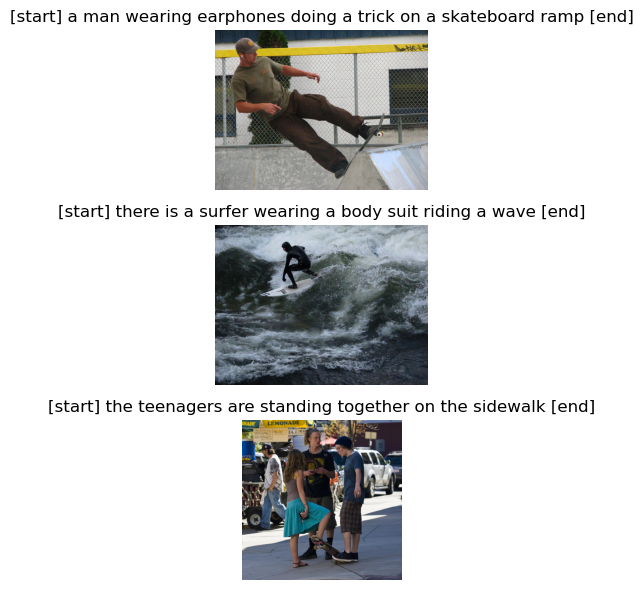

In [63]:
# Display some images and captions
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

for ax, (image_path, caption) in zip(axes.flatten(), zip(df['image'][:3], df['caption'][:3])):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(caption)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Split the data
- train_test_split is a function from sklearn.model_selection that is used to split the dataset into training and temporary sets initially, and then further split the temporary set into validation and test sets.
- test_size=0.2 indicates that 80% of the data will be used for the initial test set, and test_size=0.5 indicates that 50% of the remaining data (temporary set) will be used for the validation set.

In [64]:
# Split the data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Reset the index for each subset
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Display the sizes of each subset
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 7228
Validation set size: 903
Test set size: 904


# Setting parameters

In [65]:
# Image Dimension 
img_dimension = 299 
# Maximum Number of Words in Tokenizer Vocabulary
num_words = 10000 
# Size of the Image Encoding 
encoding_size = 256 
# Size of the LSTM (Long Short-Term Memory) units in the decoder
LSTM_size = 768 
# Batch Size for Training
batch_size = 64
# Number of Training Epochs
n_epochs = 15
# Buffer Size for Shuffling Training Data 
Buffer_size = 1000
# Number of Training Examples to Use 
num_examples = None  

# Tokenizing and padding captions
1. Tokenizer:
- The Tokenizer class is used to tokenize the text data, converting words into numerical tokens.
- The fit_on_texts method is applied to the training captions to build the vocabulary based on word frequency.
2. Convert captions to sequences of integers:
- The texts_to_sequences method is used to convert each caption in the training set into a sequence of integers based on the tokenized vocabulary.
3. Pad sequences:
- The pad_sequences function is used to ensure that all sequences have the same length by padding or truncating as needed. Padding is applied at the end of the sequences ('post'), and the maximum length is set to max_cap_len + 2.
4. Determine the number of unique words:
- The number of unique words in the vocabulary is determined based on the total number of unique tokens in the tokenizer's word index.

In [66]:
# # Create and fit the Tokenizer
tokenizer = Tokenizer(num_words = num_words, filters ="!?,'()_-+=&*$#@.",oov_token="")
tokenizer.fit_on_texts(train_df["caption"])
# Convert captions to sequences of integers
captions_train = tokenizer.texts_to_sequences(train_df["caption"])
# Pad sequences to a fixed length
captions_train = pad_sequences(captions_train, padding='post', maxlen=max_cap_len + 2)

# Determine the number of unique words in the vocabulary
words = len(tokenizer.word_index) if num_words is None else num_words
print("Unique words in vocabulary:", words)

# Print a few examples of original captions and their padded sequences
num_examples_to_print = 2
for i in range(num_examples_to_print):
    random_example_index = np.random.randint(low=0, high=len(captions_train) - 1, size=1)[0]
    original_caption = train_df["caption"].iloc[random_example_index]
    padded_sequence = captions_train[random_example_index]

    print(f"Original Caption: {original_caption}")
    print(f"Padded Sequence: {padded_sequence}")
    print("\n")
     

Unique words in vocabulary: 10000
Original Caption: [start] people are looking at a television holding wii controllers [end]
Padded Sequence: [  3  13  23  64  16   2 390  17 153 463   4   0   0   0   0   0   0]


Original Caption: [start] two individuals race around a corner on their horses [end]
Padded Sequence: [  3  18 903 571  80   2 364   5  72 167   4   0   0   0   0   0   0]




In [67]:
# val dataset
captions_valid = tokenizer.texts_to_sequences(val_df["caption"])
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

In [68]:
# test data
captions_test = tokenizer.texts_to_sequences(test_df["caption"])
captions_test= pad_sequences(captions_test, padding='post',maxlen=max_cap_len + 2)


# Preprocessing

1. The load_img function is designed to read and preprocess images for a machine learning model. It takes a file path as input, reads the image using TensorFlow's tf.io.read_file, and decodes the JPEG content with tf.image.decode_jpeg. The function then resizes the image to a specified dimension (assumed to be square) using tf.image.resize. Finally, the processed image is returned. 

In [69]:
# load images
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

2. The preprocess_func_val function prepares data for validation in a sequence-to-sequence model. It loads an image specified by path_index from the validation dataset, processes the input and target captions by removing the last and first elements, respectively. Additionally, it initializes the hidden and cell states with zeros. The function returns a tuple containing the image, initial states, and the input caption, along with the target caption for validation. 

- train data 

In [70]:
def preprocess_func(path_index, caption):
  # read the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(train_df["image"],indices=path_index)
  img = load_img(path)#/255.0
  # preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  # initialize hidden and cell states with zeros
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

- validation data

In [71]:
def preprocess_func_val(path_index, caption):
  # read the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(val_df["image"],indices=path_index)
  img = load_img(path)#/255.0
  # preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  # initialize hidden and cell states with zeros
  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

- test data

In [72]:
def preprocess_func_test(path_index, caption):
  # reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(test_df["image"],indices=path_index)
  img = load_img(path) #/255.0
  # preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  # initialize hidden and cell states with zeros
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img, h_and_c_init, teacher_caption), tar_caption 

3. creates two TensorFlow datasets
- path_index_vec_train is created as an array indexing each image path in the training set.
- Datasets (dataset1_train and dataset2_train) are created from the index array and the corresponding preprocessed captions.
- tf.data.Dataset.zip combines these datasets into a single dataset.
- The preprocess_func is applied to each element in parallel, preparing input-output pairs for the model.
- The dataset is shuffled, batched, and prefetching is applied to enhance training performance.

In [73]:
# creating an array to index each img path for reading 
#train
path_index_vec_train = np.array(list(range(0,len(train_df["image"])))).reshape(-1,1) 
dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#val
path_index_vec_val = np.array(list(range(0,len(val_df["image"])))).reshape(-1,1) 
dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# test data
path_index_vec_test = np.array(list(range(0,len(test_df["image"])))).reshape(-1,1)
dataset1_test = tf.data.Dataset.from_tensor_slices(path_index_vec_test)
dataset2_test = tf.data.Dataset.from_tensor_slices(captions_test)
dataset_test = tf.data.Dataset.zip((dataset1_test,dataset2_test))
dataset_test = dataset_test.map(preprocess_func_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [74]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256).prefetch(1)

# Building the model
- This code defines a neural network model for image captioning using the InceptionV3 architecture as a feature extractor. The InceptionV3 model is loaded with pre-trained weights, and its layers are frozen to prevent further training. The input layers include tensors for the image, teacher forcing input (caption sequence), and initial hidden state for the LSTM layer. The image input is preprocessed, encoded using a Dense layer, and flattened. The encoding is then repeated for each time step in the caption sequence. The teacher forcing input is embedded and subjected to dropout. The flattened encoding and embedded input are concatenated and fed into an LSTM layer for decoding the sequence. The LSTM output is passed through a Dense layer to predict word probabilities.

In [75]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
# Load InceptionV3 with pre-trained weights and freeze layers
incep_model = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep_model.trainable=False

In [76]:
# Input layers for the model
img = Input(shape=(img_dimension, img_dimension, 3))  # Image input tensor
teacher_forcing = Input(shape=(max_cap_len + 1))  # Teacher forcing input tensor
initial_state = Input(shape=(LSTM_size))  # Initial hidden state tensor for LSTM

# Preprocess the image input using the specified preprocessing function
img_preprocessed = preprocess_input(img)

# Encode the preprocessed image using the InceptionV3 model
encoding = incep_model(img_preprocessed)
encoding_layer = keras.layers.Dense(encoding_size, activation='relu')  # Dense layer for image encoding
encoding = encoding_layer(encoding)
encoding = Flatten()(encoding)  # Flatten the encoding to be used as input in subsequent layers

# Repeat the flattened encoding for each time step in the caption
encoding = RepeatVector(max_cap_len + 1)(encoding)

# Embedding layer for the teacher forcing input and apply dropout
embedding_layer = Embedding(words+1, 256, mask_zero=True)
dropout_on_embbeds = Dropout(0.15)

embeddings = embedding_layer(teacher_forcing)
embeddings = dropout_on_embbeds(embeddings)

# Concatenate the flattened encoding and embedded teacher forcing input
concatenated_input = Concatenate()([encoding, embeddings])

# LSTM layer for decoding the sequence
decoder_lstm_layer = LSTM(LSTM_size, return_sequences=True, return_state=True, dropout=0.2)
h = initial_state
c = initial_state

# Apply the LSTM layer to the concatenated input with initial hidden and cell states
lstm_output, h, c = decoder_lstm_layer(concatenated_input, initial_state=[h, c])

# Dense layer for outputting the predicted word probabilities
decoder_dense_layer = Dense(words + 1, activation=None, name='output_layer')
output_probabilities = decoder_dense_layer(lstm_output)

# Build the model
model = Model([img, initial_state, teacher_forcing], output_probabilities)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 299, 299, 3)  0          ['input_11[0][0]']               
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 299, 299, 3)  0          ['tf.math.truediv_1[0][0]']      
 )                                                                                                
                                                                                            

# Loss Function
- The provided code defines a custom loss function named sparse_it_up for the image captioning model. This loss function is designed to handle sparse categorical cross-entropy with masking, which is suitable for tasks where only specific elements in the sequence need to be considered for loss calculation. The function takes two arguments, y_true and y_preds, representing the true labels and predicted probabilities, respectively. It first casts the true labels to integers and creates a mask to identify non-zero elements. The true labels are then converted to one-hot encoding. Finally, the function computes the sparse categorical cross-entropy by considering the masked elements and returns the mean loss. 

In [77]:
# loss function
def sparse_it_up(y_true, y_preds):
    # Cast true labels to integers
    y_true = tf.cast(y_true, tf.int32)
    # Create a mask for non-zero elements in true labels
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.cast(mask, dtype=tf.float32)
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, words + 1)
    # Calculate sparse categorical cross-entropy with masking
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true_one_hot, y_preds) * mask)
    return loss


# Model Compile

In [78]:
# model compile
model.compile(optimizer=keras.optimizers.legacy.Nadam(0.001), loss = sparse_it_up, metrics=['accuracy'])
# Model Checkpoint Callback
Checkpoint = ModelCheckpoint('Image_captioning.hdf5',save_best_only=True, monitor='val_accuracy',verbose =1)
# Early Stopping Callback
early_stop = EarlyStopping(monitor ='val_accuracy',patience=5)
# model fit
history = model.fit(dataset, epochs=5, validation_data=dataset_val, callbacks=[early_stop,Checkpoint])

Epoch 1/5


2023-11-29 21:41:03.986548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [7228,17]
	 [[{{node Placeholder/_2}}]]
2023-11-29 21:41:03.986933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [7228,17]
	 [[{{node Placeholder/_2}}]]


113/113 [==============================] - ETA: 0s - loss: 3.8031 - accuracy: 0.1396 

2023-11-29 22:03:45.534848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [903,17]
	 [[{{node Placeholder/_2}}]]
2023-11-29 22:03:45.535393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [903,17]
	 [[{{node Placeholder/_2}}]]



Epoch 1: val_accuracy improved from -inf to 0.14599, saving model to Image_captioning.hdf5
113/113 [==============================] - 1487s 13s/step - loss: 3.8031 - accuracy: 0.1396 - val_loss: 3.6770 - val_accuracy: 0.1460
Epoch 2/5
113/113 [==============================] - ETA: 0s - loss: 3.1352 - accuracy: 0.2380 
Epoch 2: val_accuracy improved from 0.14599 to 0.29710, saving model to Image_captioning.hdf5
113/113 [==============================] - 1419s 13s/step - loss: 3.1352 - accuracy: 0.2380 - val_loss: 2.7840 - val_accuracy: 0.2971
Epoch 3/5
113/113 [==============================] - ETA: 0s - loss: 2.5261 - accuracy: 0.3127 
Epoch 3: val_accuracy improved from 0.29710 to 0.32974, saving model to Image_captioning.hdf5
113/113 [==============================] - 1513s 13s/step - loss: 2.5261 - accuracy: 0.3127 - val_loss: 2.5192 - val_accuracy: 0.3297
Epoch 4/5
113/113 [==============================] - ETA: 0s - loss: 2.2250 - accuracy: 0.3468 
Epoch 4: val_accuracy improved

In [79]:
# Load pre-trained weights into the model
model.load_weights("Image_captioning.hdf5")

# Plots

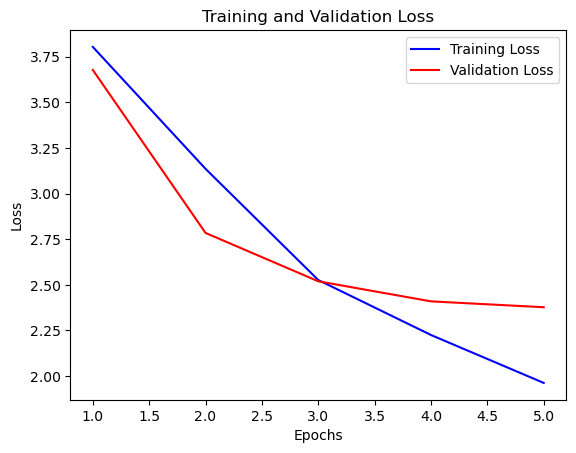

In [80]:
# Plotting Training and Validation Loss
epochs = range(1, len(history.history['accuracy']) + 1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

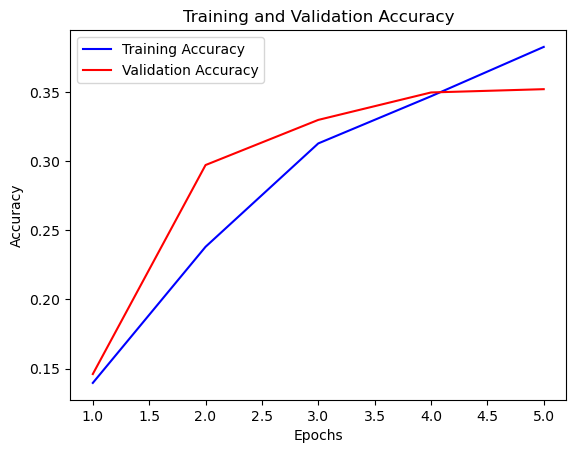

In [81]:
# Plotting Training and Validation Accuracy
epochs = range(1, len(history.history['accuracy']) + 1)
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluating the model on test dataset

In [82]:
model.evaluate(dataset_test.batch(256).prefetch(1))

2023-11-29 23:46:17.383394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [904,17]
	 [[{{node Placeholder/_2}}]]


4/4 [==============================] - 117s 27s/step - loss: 2.3790 - accuracy: 0.3458


[2.3789608478546143, 0.34578147530555725]

# Prediction

In [83]:
def build_encoder():
  img_inp = keras.layers.Input(shape=(img_dimension,img_dimension,3)),
  encodings = incep_model(img_inp)
  encodings = encoding_layer(encodings)
  encodings = keras.layers.Flatten()(encodings)
  model_encoder = keras.models.Model(img_inp,encodings)
  return model_encoder

In [84]:
pred_encoder = build_encoder()
pred_encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 dense_1 (Dense)             (None, 8, 8, 256)         524544    
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
Total params: 22,327,328
Trainable params: 524,544
Non-trainable params: 21,802,784
_________________________________________________________________


In [85]:
def decoder_model():
    # Input layers
    encodings_input = Input(shape=(8*8*encoding_size))
    teacher_forcing = Input(shape=(1))
    initial_h = Input(shape=(LSTM_size))
    initial_c = Input(shape=(LSTM_size))
    h = initial_h
    c = initial_c

    # Embedding layer
    embedds = embedding_layer(teacher_forcing)
    # Concatenate Encodings and Embeddings
    lstm_input = Concatenate()([tf.expand_dims(encodings_input,1),embedds])
    # LSTM Layer
    lstm_output , h , c = decoder_lstm_layer(lstm_input, initial_state=[h,c])
    # Softmax Layer for Output
    output = tf.nn.softmax(decoder_dense_layer(lstm_output))
    # Build the model
    model_decoder = Model([encodings_input,initial_h,initial_c,teacher_forcing],[output,h,c])
    return model_decoder

pred_decoder = decoder_model()
pred_decoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 16384)]      0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 1, 16384)     0           ['input_15[0][0]']               
                                                                                                  
 embedding_1 (Embedding)        multiple             2560256     ['input_16[0][0]']               
                                                                                            

In [86]:
def caption_image(path, true_caption):
  # Load and preprocess the image
  image = load_img(path)#/255.0
  img_input = preprocess_input(image)
  # Get image encodings using the pre-trained encoder
  encodings = pred_encoder.predict(tf.reshape(img_input,(1,img_dimension,img_dimension,3)))
  # Initialize starting token for caption generation
  texts = ["[start]"]
  # Initialize LSTM states
  h = np.zeros((1,LSTM_size))
  c = h
  # Generate captions
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tokenizer.word_index.get(texts[-1])).reshape(1,-1)
    # Predict next word probabilities and update LSTM states
    props, h, c = pred_decoder.predict([encodings, h, c ,dec_inp])
    props= props[0]
    # Get the index of the word with the highest probability
    idx = np.argmax(props)
    # Append the predicted word to the caption
    texts.append(tokenizer.index_word.get(idx))
    # Check for the end token to stop caption generation
    if idx == tokenizer.word_index['[end]']:
      break
  # Ensure that the caption ends with the end token
  if tokenizer.word_index.get(texts[-1]) != tokenizer.word_index['[end]']:
    texts.append('[end]')
    # Print the generated caption
  generated_caption = ' '.join(texts)
  print(f"Label: {true_caption}")
  print(f"Predicted: {generated_caption}")
  # Display the image along with the true caption if available
  plt.figure(figsize=(5, 5))
  plt.imshow(image/255.0)
  plt.axis("off")


1/1 [==============================] - 0s 27ms/step
Label: [start] a bunch of adults playing with the nintendo wii [end]
Predicted: [start] a man is holding a video game in a room [end]


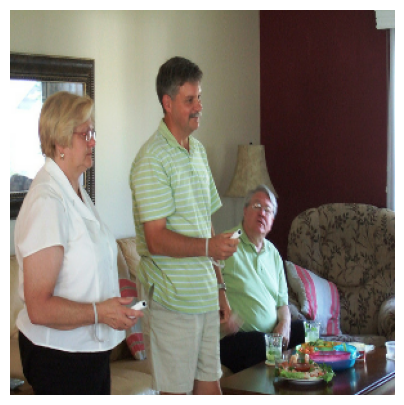

In [87]:
caption_image(test_df["image"][1],test_df["caption"][1])

1/1 [==============================] - 0s 27ms/step
Label: [start] a man is testing out how it feels to ride a harley motorcycle [end]
Predicted: [start] a man riding a motorcycle on a motorcycle [end]


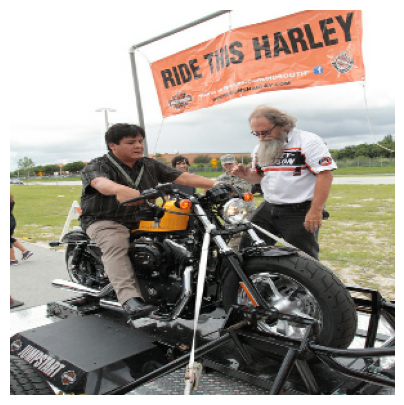

In [88]:
caption_image(test_df["image"][2],test_df["caption"][2])

1/1 [==============================] - 0s 27ms/step
Label: [start] a public space with a statue of a bird and a large clock [end]
Predicted: [start] a group of people walking down a street sign [end]


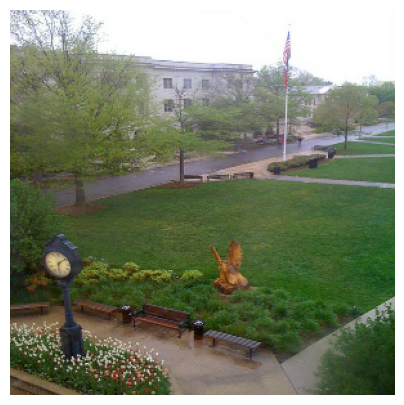

In [89]:
caption_image(test_df["image"][10],test_df["caption"][10])

1/1 [==============================] - 0s 27ms/step
Label: [start] a dog laying down with its tongue hanging out clutching a hat [end]
Predicted: [start] a man is sitting on a bench with a dog [end]


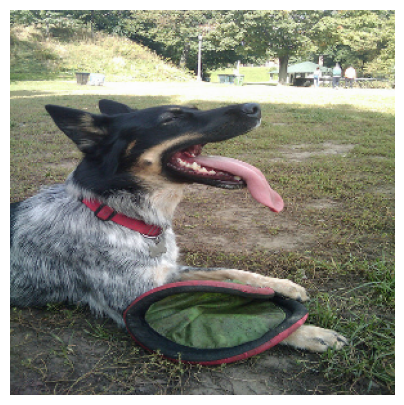

In [90]:
caption_image(test_df["image"][20],test_df["caption"][20])

1/1 [==============================] - 0s 27ms/step
Label: [start] man and a woman standing inside of a kitchen area [end]
Predicted: [start] a man is sitting in a kitchen [end]


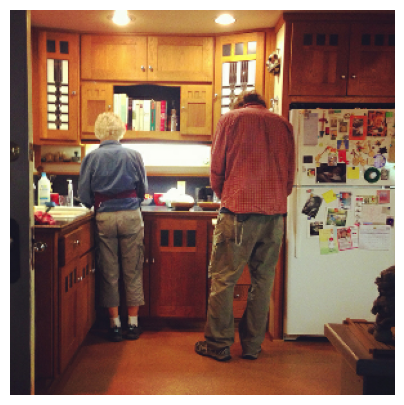

In [91]:
caption_image(test_df["image"][30],test_df["caption"][30])

1/1 [==============================] - 0s 28ms/step
Label: [start] a small boat on a body of water [end]
Predicted: [start] a man is sitting on a bench [end]


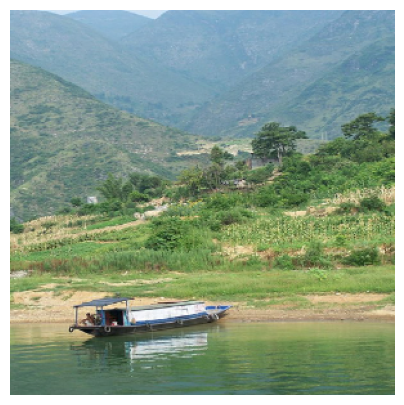

In [96]:
caption_image(test_df["image"][34],test_df["caption"][34])

1/1 [==============================] - 0s 28ms/step
Label: [start] person in blue hooded coat cross country skiing away from camera [end]
Predicted: [start] a person is skiing on the snow on the snow [end]


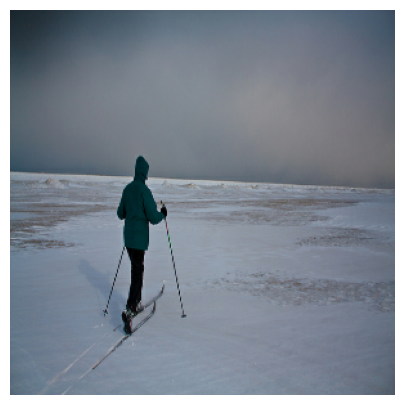

In [97]:
caption_image(test_df["image"][50],test_df["caption"][50])

# Saving the model and tokenizer's dictionary

In [92]:
pred_encoder.save("Encoder.hdf5")
pred_decoder.save("Decoder.hdf5")

In [93]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Testing if just want to recall the model

In [94]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

encoder = keras.models.load_model("Encoder.hdf5")
decoder = keras.models.load_model("Decoder.hdf5")
import pickle
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

def caption_image(path, true_caption):
  # Load and preprocess the image
  image = load_img(path)#/255.0
  img_input = preprocess_input(image)
  # Get image encodings using the pre-trained encoder
  encodings = pred_encoder.predict(tf.reshape(img_input,(1,img_dimension,img_dimension,3)))
  # Initialize starting token for caption generation
  texts = ["[start]"]
  # Initialize LSTM states
  h = np.zeros((1,LSTM_size))
  c = h
  # Generate captions
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tokenizer.word_index.get(texts[-1])).reshape(1,-1)
    # Predict next word probabilities and update LSTM states
    props, h, c = pred_decoder.predict([encodings, h, c ,dec_inp])
    props= props[0]
    # Get the index of the word with the highest probability
    idx = np.argmax(props)
    # Append the predicted word to the caption
    texts.append(tokenizer.index_word.get(idx))
    # Check for the end token to stop caption generation
    if idx == tokenizer.word_index['[end]']:
      break
  # Ensure that the caption ends with the end token
  if tokenizer.word_index.get(texts[-1]) != tokenizer.word_index['[end]']:
    texts.append('[end]')
    # Print the generated caption
  generated_caption = ' '.join(texts)
  print(f"Label: {true_caption}")
  print(f"Predicted: {generated_caption}")
  # Display the image along with the true caption if available
  plt.figure(figsize=(5, 5))
  plt.imshow(image/255.0)
  plt.axis("off")


1/1 [==============================] - 0s 27ms/step
Label: [start] a dog laying down with its tongue hanging out clutching a hat [end]
Predicted: [start] a man is sitting on a bench with a dog [end]


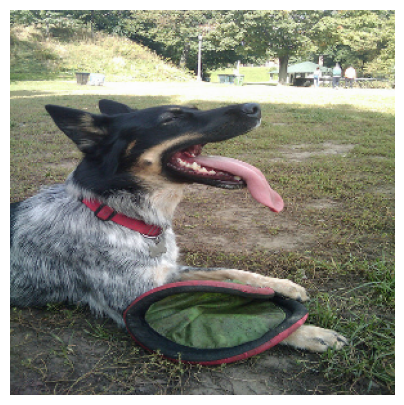

In [95]:
caption_image(test_df["image"][20],test_df["caption"][20])